<a href="https://colab.research.google.com/github/ankesh86/PySparkNotebooks/blob/main/Unsupervised_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Reviewing the Dataset**

## **Importing SparkSession and Creating an object**

In [1]:
!pip install pyspark==3.4.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317122 sha256=353fc4897dfbb1e384aab945aae8706a0923b4c984d8c0e25ac254f8504dbf80
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


In [3]:
import pyspark
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.functions import rand, randn
from pyspark.ml.clustering import KMeans
from pyspark.sql.functions import sha2

In [5]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('unsupervised_ml').getOrCreate()

In [6]:
df=spark.read.csv('sample_data/music_data.csv',inferSchema=True, header=True)
df.count()

429023

In [7]:
df.printSchema()

root
 |-- user_id: string (nullable = true)
 |-- music category: string (nullable = true)



In [8]:
df.select('music category').distinct().count()

21

In [9]:
df.groupBy('music category').count().orderBy('count', ascending=False).show(100,False)

+-----------------+-----+
|music category   |count|
+-----------------+-----+
|Alternative Music|64227|
|Blues            |54647|
|Classical Music  |43117|
|Country Music    |39891|
|Dance Music      |35779|
|Easy Listening   |34356|
|Electronic Music |30985|
|Rap              |29569|
|Hip Hop          |16895|
|Indie Pop        |16244|
|Motivational     |10118|
|Asian Pop        |8444 |
|Jazz             |7685 |
|Latin Music      |7302 |
|New Age          |7053 |
|Opera            |6188 |
|Hindi Music      |5689 |
|Popular          |4729 |
|Soulful          |2403 |
|Reggae           |1970 |
|Rock             |1732 |
+-----------------+-----+



In [10]:
df.select('user_id').distinct().count()

775

In [11]:
df.groupBy('user_id').count().orderBy('count',ascending=False).show(20,False)

+----------------------------------------------------------------+-----+
|user_id                                                         |count|
+----------------------------------------------------------------+-----+
|628119a73b9725466e6c309f803d30cfc3b11d2a426cdd5f0d62a496e105c914|14257|
|179dd34be075e729f14dadc28a34459226c4f62797af5f186bddbb7428b8fc78|11804|
|2d765ea4ffc6554c95a1c703afcd3470bc118a65c2f0728871f4d0f40628f41b|11001|
|ca60aad85306a7fdd51a469ca6a5d27109dfd5f5781d7da985c70574d2520d23|10479|
|03bfd7e24d3a7ce9e3973f9d42ad89e4c1710b89bec59b2b08712ba73372dcbc|10075|
|7660ca8a4f5df748976aac001d5f0c5b7c8806f5c08197542d26c2eac4b20f85|9932 |
|b6eb8ef9cacc79b6779a7e065c3b0fb5174397ea983d70453bc978b6e46f95e2|7694 |
|e92f348b4a29089c9d7b82095d0bd49422153b60bbde08527015121e44699990|7210 |
|da03e0ef521fecb209f01410eefff11c115fda2d217dde51fd870761b31bb968|7182 |
|04cd1fc5c925a8a702607d6c1a047b8e0cbe170bdaed5270369d321f73254b53|6853 |
|a2374ccb47b0af60aafabeed11b979acf0d72e1afe7f96b671

In [12]:
df.groupBy('user_id').count().orderBy('count',ascending=True).show(20,False)

+----------------------------------------------------------------+-----+
|user_id                                                         |count|
+----------------------------------------------------------------+-----+
|54f2e60bd31a775aca7fb60816c6990a415fe66694098d1ee64cc9e13f831a64|1    |
|a09074b27cd4ab61654c0f4e21bc5e97dc86a611743a1f8b37db3a76df8e306e|1    |
|402c7aac3776a3758ca143819a0653c6cd33c6c35dd831d9ba5aad1dff43a888|1    |
|1e3e7153bf1aa5f43b1d1f27c940087587a50d40d399f4cf31b58546a39b9f26|1    |
|4d5920f000b000d60fdc63043886f47cc056d2835d3a73e50f389a5694b19115|1    |
|ecb27d9bf54e751018cd6c1cc5a0f2d812ff08585271acfc980bdacb742a7a02|1    |
|bdb448f271ec83b324acd32248f1401964cb1f5f716e94eebed508f02e889e14|1    |
|e6e6ceb674b7ca53391ac404558a3f8d222db82c643b8c21070db4f029a50095|1    |
|8691b41f5ae65644c8aca0ec9d738eb3b5537b106f0fdcb3f652cc77b7ab7dd6|1    |
|8aced64c96741dbeab4659f102f34c157189b3f7a63807d87bad5d8c663005cb|1    |
|55efc631da61b192de874d5e2b05ea1e04ec08bd2e3009ebcd

## **Reshaping a Dataframe for Clustering**

In [13]:
feature_df = df.stat.crosstab("user_id","music category")
feature_df.printSchema()

root
 |-- user_id_music category: string (nullable = true)
 |-- Alternative Music: long (nullable = false)
 |-- Asian Pop: long (nullable = false)
 |-- Blues: long (nullable = false)
 |-- Classical Music: long (nullable = false)
 |-- Country Music: long (nullable = false)
 |-- Dance Music: long (nullable = false)
 |-- Easy Listening: long (nullable = false)
 |-- Electronic Music: long (nullable = false)
 |-- Hindi Music: long (nullable = false)
 |-- Hip Hop: long (nullable = false)
 |-- Indie Pop: long (nullable = false)
 |-- Jazz: long (nullable = false)
 |-- Latin Music: long (nullable = false)
 |-- Motivational: long (nullable = false)
 |-- New Age: long (nullable = false)
 |-- Opera: long (nullable = false)
 |-- Popular: long (nullable = false)
 |-- Rap: long (nullable = false)
 |-- Reggae: long (nullable = false)
 |-- Rock: long (nullable = false)
 |-- Soulful: long (nullable = false)



In [14]:
feature_df.show(3,False)

+----------------------------------------------------------------+-----------------+---------+-----+---------------+-------------+-----------+--------------+----------------+-----------+-------+---------+----+-----------+------------+-------+-----+-------+---+------+----+-------+
|user_id_music category                                          |Alternative Music|Asian Pop|Blues|Classical Music|Country Music|Dance Music|Easy Listening|Electronic Music|Hindi Music|Hip Hop|Indie Pop|Jazz|Latin Music|Motivational|New Age|Opera|Popular|Rap|Reggae|Rock|Soulful|
+----------------------------------------------------------------+-----------------+---------+-----+---------------+-------------+-----------+--------------+----------------+-----------+-------+---------+----+-----------+------------+-------+-----+-------+---+------+----+-------+
|f0aead442015795909760d6557c0ac7228a2b5beeedeb5daf2de29040c528f22|58               |0        |4    |2              |4            |7          |29            |

In [15]:
feature_df.count()

775

In [16]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [17]:
print(feature_df.columns)

['user_id_music category', 'Alternative Music', 'Asian Pop', 'Blues', 'Classical Music', 'Country Music', 'Dance Music', 'Easy Listening', 'Electronic Music', 'Hindi Music', 'Hip Hop', 'Indie Pop', 'Jazz', 'Latin Music', 'Motivational', 'New Age', 'Opera', 'Popular', 'Rap', 'Reggae', 'Rock', 'Soulful']


In [18]:
feat_cols = [col for col in feature_df.columns if col != 'user_id_music category']
print(feat_cols)

['Alternative Music', 'Asian Pop', 'Blues', 'Classical Music', 'Country Music', 'Dance Music', 'Easy Listening', 'Electronic Music', 'Hindi Music', 'Hip Hop', 'Indie Pop', 'Jazz', 'Latin Music', 'Motivational', 'New Age', 'Opera', 'Popular', 'Rap', 'Reggae', 'Rock', 'Soulful']


In [19]:
vec_assembler = VectorAssembler(inputCols= feat_cols, outputCol='features')
final_data = vec_assembler.transform(feature_df)

final_data.printSchema()

root
 |-- user_id_music category: string (nullable = true)
 |-- Alternative Music: long (nullable = false)
 |-- Asian Pop: long (nullable = false)
 |-- Blues: long (nullable = false)
 |-- Classical Music: long (nullable = false)
 |-- Country Music: long (nullable = false)
 |-- Dance Music: long (nullable = false)
 |-- Easy Listening: long (nullable = false)
 |-- Electronic Music: long (nullable = false)
 |-- Hindi Music: long (nullable = false)
 |-- Hip Hop: long (nullable = false)
 |-- Indie Pop: long (nullable = false)
 |-- Jazz: long (nullable = false)
 |-- Latin Music: long (nullable = false)
 |-- Motivational: long (nullable = false)
 |-- New Age: long (nullable = false)
 |-- Opera: long (nullable = false)
 |-- Popular: long (nullable = false)
 |-- Rap: long (nullable = false)
 |-- Reggae: long (nullable = false)
 |-- Rock: long (nullable = false)
 |-- Soulful: long (nullable = false)
 |-- features: vector (nullable = true)



In [21]:
final_data.show(10,False)

+----------------------------------------------------------------+-----------------+---------+-----+---------------+-------------+-----------+--------------+----------------+-----------+-------+---------+----+-----------+------------+-------+-----+-------+---+------+----+-------+----------------------------------------------------------------------------------------------------------+
|user_id_music category                                          |Alternative Music|Asian Pop|Blues|Classical Music|Country Music|Dance Music|Easy Listening|Electronic Music|Hindi Music|Hip Hop|Indie Pop|Jazz|Latin Music|Motivational|New Age|Opera|Popular|Rap|Reggae|Rock|Soulful|features                                                                                                  |
+----------------------------------------------------------------+-----------------+---------+-----+---------------+-------------+-----------+--------------+----------------+-----------+-------+---------+----+-----------+---

In [23]:
from pyspark.ml.feature import StandardScaler
#scaling the features
scaler = StandardScaler(inputCol="features",outputCol="scaledFeatures", withStd=True, withMean=False)
# Compute summary statistics by fitting the StandardScaler
scalerModel = scaler.fit(final_data)


In [24]:
# Normalize each feature to have unit standard deviation.
cluster_final_data = scalerModel.transform(final_data)
cluster_final_data.columns

['user_id_music category',
 'Alternative Music',
 'Asian Pop',
 'Blues',
 'Classical Music',
 'Country Music',
 'Dance Music',
 'Easy Listening',
 'Electronic Music',
 'Hindi Music',
 'Hip Hop',
 'Indie Pop',
 'Jazz',
 'Latin Music',
 'Motivational',
 'New Age',
 'Opera',
 'Popular',
 'Rap',
 'Reggae',
 'Rock',
 'Soulful',
 'features',
 'scaledFeatures']

In [25]:
cluster_final_data.show(10,False)

+----------------------------------------------------------------+-----------------+---------+-----+---------------+-------------+-----------+--------------+----------------+-----------+-------+---------+----+-----------+------------+-------+-----+-------+---+------+----+-------+----------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|user_id_music category                                          |Alternative Music|Asian Pop|Blues|Classical Music|Country Music|Dance Music|Easy Listening|Electronic Music|Hindi Music|Hip Hop|Indie Pop|Jazz|Latin 

## **Building Clusters with K-Means**

In [28]:
errors = []

for k in range(2, 10):
    kmeans = KMeans(featuresCol='scaledFeatures', k=k)
    model = kmeans.fit(cluster_final_data)
    wssse = model.summary.trainingCost
    errors.append(wssse)
    print("With K={}".format(k))
    print("Within Set Sum of Squared Errors = " + str(wssse))
    print('--' * 30)

With K=2
Within Set Sum of Squared Errors = 12858.324030256734
------------------------------------------------------------
With K=3
Within Set Sum of Squared Errors = 12227.554588101746
------------------------------------------------------------
With K=4
Within Set Sum of Squared Errors = 11729.958894079231
------------------------------------------------------------
With K=5
Within Set Sum of Squared Errors = 11424.1997443399
------------------------------------------------------------
With K=6
Within Set Sum of Squared Errors = 9906.800633429164
------------------------------------------------------------
With K=7
Within Set Sum of Squared Errors = 9370.6428258546
------------------------------------------------------------
With K=8
Within Set Sum of Squared Errors = 9132.53446343389
------------------------------------------------------------
With K=9
Within Set Sum of Squared Errors = 8218.503221783649
------------------------------------------------------------


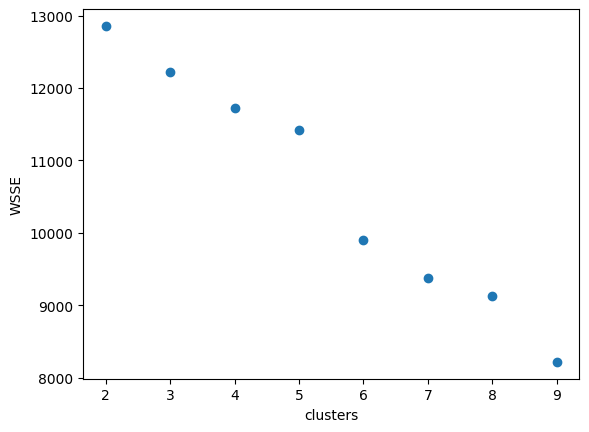

In [29]:
cluster_number = range(2,10)
plt.scatter(cluster_number, errors)
plt.xlabel('clusters')
plt.ylabel('WSSE')
plt.show()

In [30]:
kmeans6 = KMeans(featuresCol='scaledFeatures',k=6)
model_k6 = kmeans6.fit(cluster_final_data)
model_k6.transform(cluster_final_data).groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|    3|
|         3|   47|
|         5|    1|
|         4|    2|
|         2|    3|
|         0|  719|
+----------+-----+



In [31]:
model_k6.transform(cluster_final_data).show()

+----------------------+-----------------+---------+-----+---------------+-------------+-----------+--------------+----------------+-----------+-------+---------+----+-----------+------------+-------+-----+-------+---+------+----+-------+--------------------+--------------------+----------+
|user_id_music category|Alternative Music|Asian Pop|Blues|Classical Music|Country Music|Dance Music|Easy Listening|Electronic Music|Hindi Music|Hip Hop|Indie Pop|Jazz|Latin Music|Motivational|New Age|Opera|Popular|Rap|Reggae|Rock|Soulful|            features|      scaledFeatures|prediction|
+----------------------+-----------------+---------+-----+---------------+-------------+-----------+--------------+----------------+-----------+-------+---------+----+-----------+------------+-------+-----+-------+---+------+----+-------+--------------------+--------------------+----------+
|  f0aead44201579590...|               58|        0|    4|              2|            4|          7|            29|         

In [32]:
cluster_prediction=model_k6.transform(cluster_final_data)
cluster_prediction.printSchema()

root
 |-- user_id_music category: string (nullable = true)
 |-- Alternative Music: long (nullable = false)
 |-- Asian Pop: long (nullable = false)
 |-- Blues: long (nullable = false)
 |-- Classical Music: long (nullable = false)
 |-- Country Music: long (nullable = false)
 |-- Dance Music: long (nullable = false)
 |-- Easy Listening: long (nullable = false)
 |-- Electronic Music: long (nullable = false)
 |-- Hindi Music: long (nullable = false)
 |-- Hip Hop: long (nullable = false)
 |-- Indie Pop: long (nullable = false)
 |-- Jazz: long (nullable = false)
 |-- Latin Music: long (nullable = false)
 |-- Motivational: long (nullable = false)
 |-- New Age: long (nullable = false)
 |-- Opera: long (nullable = false)
 |-- Popular: long (nullable = false)
 |-- Rap: long (nullable = false)
 |-- Reggae: long (nullable = false)
 |-- Rock: long (nullable = false)
 |-- Soulful: long (nullable = false)
 |-- features: vector (nullable = true)
 |-- scaledFeatures: vector (nullable = true)
 |-- predic

## **PCA - Dimensionality Reduction**

In [33]:
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors

In [34]:
pca = PCA(k=3, inputCol="scaledFeatures", outputCol="pca_features")
pca_model  = pca.fit(cluster_prediction)

result = pca_model.transform(cluster_prediction).select('user_id_music category','pca_features','prediction')

In [35]:
result.show(truncate=False)

+----------------------------------------------------------------+--------------------------------------------------------------------+----------+
|user_id_music category                                          |pca_features                                                        |prediction|
+----------------------------------------------------------------+--------------------------------------------------------------------+----------+
|f0aead442015795909760d6557c0ac7228a2b5beeedeb5daf2de29040c528f22|[-0.4292752500730784,0.371696214465941,-0.07672747333499305]        |0         |
|113e8bf3d09529d0cc246227019e26d4463a72820c298864be6c651d29dcf6e4|[-4.3736310646886905,1.5691189605286466,-0.08275543449067334]       |3         |
|d20e466a7b1817e9efd791d9b80c87c8eeffe50f091ab7ad8206e7416f3defed|[-0.6698144701036585,0.22262413940175185,-0.14108133637167658]      |0         |
|9b126a6f98cb8d162f56c4c6b19f0a56656bcd9a5227a68406e6065f0a3b81e0|[-1.0987585365868786,0.6834285979074631,-0.821130595

## PCA DF to Pandas df

In [36]:
clusters = result.toPandas().set_index('user_id_music category')
clusters.head(10)

,pca_features,prediction
user_id_music category,,
f0aead442015795909760d6557c0ac7228a2b5beeedeb5daf2de29040c528f22,"[-0.4292752500730784, 0.371696214465941, -0.07...",0
113e8bf3d09529d0cc246227019e26d4463a72820c298864be6c651d29dcf6e4,"[-4.3736310646886905, 1.5691189605286466, -0.0...",3
d20e466a7b1817e9efd791d9b80c87c8eeffe50f091ab7ad8206e7416f3defed,"[-0.6698144701036585, 0.22262413940175185, -0....",0
9b126a6f98cb8d162f56c4c6b19f0a56656bcd9a5227a68406e6065f0a3b81e0,"[-1.0987585365868786, 0.6834285979074631, -0.8...",0
87b0bba0e0cd5de24fa81ad84ada517eaef2390f0d189cd602dc5a6ba8a8f454,"[-0.14748441025903347, 0.00045039230544986417,...",0
11823c5255dc7ec28e8a60ec7c079136e914a155c631474b6a6a2ac217335e34,"[-1.830562004873477, 1.2863353697184674, -0.07...",0
e7fbd81ffdc83686931bb800157063e78de9dabee0d1eb6b3885fb9658ab0c72,"[-0.7824083382846667, 0.42048110631362634, -0....",0
c35319ee2098f691c5c90e35bb7a68f5b679d3eab1f6b955f27bad71ee907ab8,"[-3.6798756375717607, 3.7888362620194953, -0.9...",3
586c34c75e5d16597cf974a34e2cba6720521a238971e4abf988b5c711adbfae,"[-0.9768104631666614, 1.3437048503088849, 0.06...",0


In [37]:
clusters[['x','y','z']] = pd.DataFrame(clusters.pca_features.values.tolist(), index=clusters.index)
del clusters['pca_features']
clusters.head(10)

,prediction,x,y,z
user_id_music category,,,,
f0aead442015795909760d6557c0ac7228a2b5beeedeb5daf2de29040c528f22,0,-0.429275,0.371696,-0.076727
113e8bf3d09529d0cc246227019e26d4463a72820c298864be6c651d29dcf6e4,3,-4.373631,1.569119,-0.082755
d20e466a7b1817e9efd791d9b80c87c8eeffe50f091ab7ad8206e7416f3defed,0,-0.669814,0.222624,-0.141081
9b126a6f98cb8d162f56c4c6b19f0a56656bcd9a5227a68406e6065f0a3b81e0,0,-1.098759,0.683429,-0.821131
87b0bba0e0cd5de24fa81ad84ada517eaef2390f0d189cd602dc5a6ba8a8f454,0,-0.147484,0.000450,-0.057861
11823c5255dc7ec28e8a60ec7c079136e914a155c631474b6a6a2ac217335e34,0,-1.830562,1.286335,-0.078945
e7fbd81ffdc83686931bb800157063e78de9dabee0d1eb6b3885fb9658ab0c72,0,-0.782408,0.420481,-0.134903
c35319ee2098f691c5c90e35bb7a68f5b679d3eab1f6b955f27bad71ee907ab8,3,-3.679876,3.788836,-0.912343
586c34c75e5d16597cf974a34e2cba6720521a238971e4abf988b5c711adbfae,0,-0.976810,1.343705,0.065893


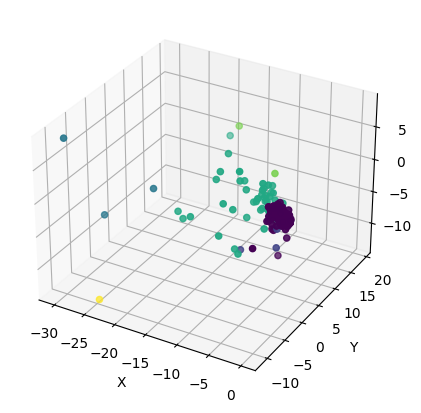

In [41]:
from mpl_toolkits.mplot3d import Axes3D

# Create a figure
fig = plt.figure(figsize=(5, 5))

# Add a 3D subplot
cluster_vis = fig.add_subplot(111, projection='3d')

# Scatter plot
cluster_vis.scatter(clusters.x, clusters.y, clusters.z, c=clusters.prediction)

# Setting labels
cluster_vis.set_xlabel('X')
cluster_vis.set_ylabel('Y')
cluster_vis.set_zlabel('Z')

# Show the plot
plt.show()